# Analyses related to 3'UTR shortening

Files: `./data/filtered_pas_expression.tsv` and `./data/filtered_pas_positions.tsv` are the output of _PAQR_.  

Running this notebook requires genomic resources present in the `./data` directory too. However, these files are too big to put them into the git repository.  
We use `Homo_sapiens.GRCh38.90.chr.gtf` and `Homo_sapiens.GRCh38.dna_sm.primary_assembly.fa` downloaded from: https://www.ensembl.org/info/data/ftp/index.html

In [55]:
import os
import re
import yaml
import glob
from IPython.display import display, HTML, Image
import numpy as np
import scipy as sp
import pandas as pd
import pybedtools
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import rpy2.rinterface
%load_ext rpy2.ipython
sns.set_context("poster")
sns.set_style("ticks")
display.max_columns = 100

notebook_outdir = "report-outdir"
os.makedirs(notebook_outdir)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [56]:
"""
GTF.py
Kamil Slowikowski
December 24, 2013

Read GFF/GTF files. Works with gzip compressed files and pandas.

    http://useast.ensembl.org/info/website/upload/gff.html

LICENSE

This is free and unencumbered software released into the public domain.
Anyone is free to copy, modify, publish, use, compile, sell, or
distribute this software, either in source code form or as a compiled
binary, for any purpose, commercial or non-commercial, and by any
means.

In jurisdictions that recognize copyright laws, the author or authors
of this software dedicate any and all copyright interest in the
software to the public domain. We make this dedication for the benefit
of the public at large and to the detriment of our heirs and
successors. We intend this dedication to be an overt act of
relinquishment in perpetuity of all present and future rights to this
software under copyright law.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND,
EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF
MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT.
IN NO EVENT SHALL THE AUTHORS BE LIABLE FOR ANY CLAIM, DAMAGES OR
OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE,
ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR
OTHER DEALINGS IN THE SOFTWARE.

For more information, please refer to <http://unlicense.org/>
"""


from collections import defaultdict
import gzip
import pandas as pd
import re


GTF_HEADER  = ['seqname', 'source', 'feature', 'start', 'end', 'score',
               'strand', 'frame']
R_SEMICOLON = re.compile(r'\s*;\s*')
R_COMMA     = re.compile(r'\s*,\s*')
R_KEYVALUE  = re.compile(r'(\s+|\s*=\s*)')


def dataframe(filename):
    """Open an optionally gzipped GTF file and return a pandas.DataFrame.
    """
    # Each column is a list stored as a value in this dict.
    result = defaultdict(list)

    for i, line in enumerate(lines(filename)):
        for key in line.keys():
            # This key has not been seen yet, so set it to None for all
            # previous lines.
            if key not in result:
                result[key] = [None] * i

        # Ensure this row has some value for each column.
        for key in result.keys():
            result[key].append(line.get(key, None))

    return pd.DataFrame(result)


def lines(filename):
    """Open an optionally gzipped GTF file and generate a dict for each line.
    """
    fn_open = gzip.open if filename.endswith('.gz') else open

    with fn_open(filename) as fh:
        for line in fh:
            if line.startswith('#'):
                continue
            else:
                yield parse(line)


def parse(line):
    """Parse a single GTF line and return a dict.
    """
    result = {}

    fields = line.rstrip().split('\t')

    for i, col in enumerate(GTF_HEADER):
        result[col] = _get_value(fields[i])

    # INFO field consists of "key1=value;key2=value;...".
    infos = [x for x in re.split(R_SEMICOLON, fields[8]) if x.strip()]

    for i, info in enumerate(infos, 1):
        # It should be key="value".
        try:
            key, _, value = re.split(R_KEYVALUE, info, 1)
        # But sometimes it is just "value".
        except ValueError:
            key = 'INFO{}'.format(i)
            value = info
        # Ignore the field if there is no value.
        if value:
            result[key] = _get_value(value)

    return result


def _get_value(value):
    if not value:
        return None

    # Strip double and single quotes.
    value = value.strip('"\'')

    # Return a list if the value has a comma.
    if ',' in value:
        value = re.split(R_COMMA, value)
    # These values are equivalent to None.
    elif value in ['', '.', 'NA']:
        return None

    return value


Read the data.

In [57]:
gtf = dataframe("./data/Homo_sapiens.GRCh38.90.chr.gtf")

In [58]:
working_gtf = gtf[gtf["feature"]=="transcript"].copy()
working_gtf = working_gtf.set_index("transcript_id")
working_gtf = working_gtf[["gene_name"]]
transcript_dict = {i:row["gene_name"] for i,row in working_gtf.iterrows()}

In [59]:
expression_df = pd.read_csv("./data/filtered_pas_expression.tsv", sep="\t")
positions_df = pd.read_csv("./data/filtered_pas_positions.tsv", sep="\t", index_col=0, header=None)
positions_df.index.name = "pas"
positions_df.columns = ["position"]

In [60]:
samples_columns = ["25-KD-2", "25-KD-3", "25-OE-1", "25-OE-2", "25-OE-3", "68-KD-1", "68-KD-2", "68-KD-3", "68-OE-1", "68-OE-2", "68-OE-3", "WT-1", "WT-2", "WT-3"]
expression_df.columns = list(expression_df.columns.values[:10]) + samples_columns

Calculate sites' usages.

In [61]:
usage_df = expression_df.copy()
df_list = []

for exon, df in usage_df.groupby(by="exon"):
    assert len(df) > 1
    
    # over each RNA sample
    for col in samples_columns:
        total_expression = sum(df[col])
        
        if total_expression == 0:
            # over each pas
            for index in df.index.values:
                df.at[index,col] = 0  
        
        else:
            # over each pas
            for index in df.index.values:
                df.at[index,col] = df.at[index,col] / total_expression
    
    df_list.append(df)

In [62]:
usage_df_full = pd.concat(df_list).sort_index()
usage_df = usage_df_full[samples_columns]

Calculate weighted average terminal exon lengths.

In [63]:
grouped = usage_df_full.groupby('exon')

In [64]:
# prepare dataframe for the weighted average terminal exon length
waTElen = pd.DataFrame(index = set(usage_df_full["exon"]), columns = samples_columns)

for exon, exondf in grouped: # over each terminal exon
    for sample in samples_columns: # for each rnaseq sample
        # calculate the weighted average terminal exon length in a given sample:
        weighted_positions = []
        for i, row in exondf.iterrows():
            position = float(positions_df.at[row["pas"],"position"])
            weighted_positions.append(position * row[sample])
        weighted_avg_position = sum(weighted_positions)
        waTElen.at[exon,sample] = weighted_avg_position

In [65]:
waTElen['avg-25-KD'] = waTElen.apply(lambda row: np.mean([row["25-KD-2"],row["25-KD-3"]]), axis=1)
waTElen['avg-25-OE'] = waTElen.apply(lambda row: np.mean([row["25-OE-1"],row["25-OE-2"],row["25-OE-3"]]), axis=1)
waTElen['avg-68-KD'] = waTElen.apply(lambda row: np.mean([row["68-KD-1"],row["68-KD-2"],row["68-KD-3"]]), axis=1)
waTElen['avg-68-OE'] = waTElen.apply(lambda row: np.mean([row["68-OE-1"],row["68-OE-2"],row["68-OE-3"]]), axis=1)
waTElen['avg-WT'] = waTElen.apply(lambda row: np.mean([row["WT-1"],row["WT-2"],row["WT-3"]]), axis=1)

In [66]:
new_columns = ["avg-WT", "avg-25-OE", "avg-25-KD", "avg-68-OE", "avg-68-KD"]
avg_waTElen = waTElen[new_columns].copy()
avg_waTElen.to_csv(notebook_outdir + "/avg_relative_exon_length.tsv", sep='\t')

In [67]:
del waTElen["avg-WT"]
del waTElen["avg-25-OE"]
del waTElen["avg-25-KD"]
del waTElen["avg-68-OE"]
del waTElen["avg-68-KD"]
waTElen = waTElen.astype(float)

Plot CDFs of terminal exon lengths:

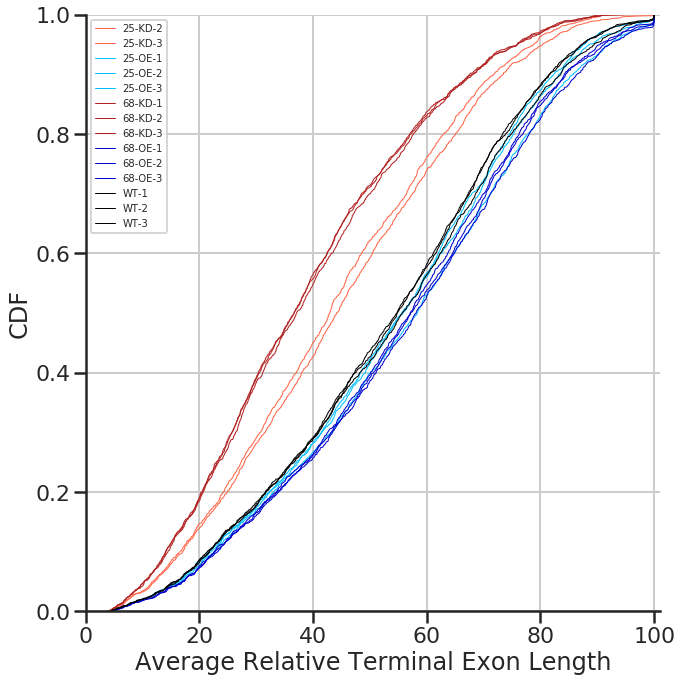

In [68]:
colors = ["tomato","tomato","deepskyblue","deepskyblue","deepskyblue","firebrick","firebrick","firebrick","mediumblue","mediumblue","mediumblue","black","black","black"]

fig = plt.figure(figsize=(10,10))
ax = plt.gca()
for s,x in zip(waTElen.columns.values, colors):
    sorted_data = np.sort(waTElen[s])
    assert 0.0 not in sorted_data
    p = 1. * np.arange(len(sorted_data))/(len(sorted_data) - 1)
    plt.plot(sorted_data, p, label=s, linewidth=1.0, color=x)
ax.set_xlim([0,101])
ax.set_ylim([0,1])
plt.xlabel("Average Relative Terminal Exon Length")
plt.ylabel("CDF")
plt.grid(True)
plt.legend(loc=2, prop={'size': 10})
plt.tight_layout()
sns.despine()
fig.savefig(notebook_outdir + "/te_len_CDF.pdf", format='pdf')
fig.savefig(notebook_outdir + "/te_len_CDF.svg", format='svg')
plt.show()
plt.close()

Scatterplots of average lengths (condition vs. WT):

In [69]:
waTElen['avg-25-KD'] = waTElen.apply(lambda row: np.mean([row["25-KD-2"],row["25-KD-3"]]), axis=1)
waTElen['avg-25-OE'] = waTElen.apply(lambda row: np.mean([row["25-OE-1"],row["25-OE-2"],row["25-OE-3"]]), axis=1)
waTElen['avg-68-KD'] = waTElen.apply(lambda row: np.mean([row["68-KD-1"],row["68-KD-2"],row["68-KD-3"]]), axis=1)
waTElen['avg-68-OE'] = waTElen.apply(lambda row: np.mean([row["68-OE-1"],row["68-OE-2"],row["68-OE-3"]]), axis=1)
waTElen['avg-WT'] = waTElen.apply(lambda row: np.mean([row["WT-1"],row["WT-2"],row["WT-3"]]), axis=1)

In [70]:
fig, axs = plt.subplots(1, 2, figsize = (10,5))

axs[0].scatter(waTElen["avg-WT"], waTElen["avg-25-OE"], alpha=1, s=1, c="black")
axs[0].plot([0, 100], [0, 100], 'k-', color = 'r', linewidth = 1.0)
axs[0].set_xlabel('WT', fontsize = 12)
axs[0].set_ylabel('25-OE', fontsize = 12)

axs[1].scatter(waTElen["avg-WT"], waTElen["avg-25-KD"], alpha=1, s=1, c="black")
axs[1].plot([0, 100], [0, 100], 'k-', color = 'r', linewidth = 1.0)
axs[1].set_xlabel('WT', fontsize = 12)
axs[1].set_ylabel('25-KD', fontsize = 12)

plt.tight_layout()
sns.despine()
fig.savefig(notebook_outdir + "/te_len_CFI25.pdf", format='pdf')
fig.savefig(notebook_outdir + "/te_len_CFI25.svg", format='svg')
plt.close()

fig, axs = plt.subplots(1, 2, figsize = (10,5))

axs[0].scatter(waTElen["avg-WT"], waTElen["avg-68-OE"], alpha=1, s=1, c="black")
axs[0].plot([0, 100], [0, 100], 'k-', color = 'r', linewidth = 1.0)
axs[0].set_xlabel('WT', fontsize = 12)
axs[0].set_ylabel('68-OE', fontsize = 12)

axs[1].scatter(waTElen["avg-WT"], waTElen["avg-68-KD"], alpha=1, s=1, c="black")
axs[1].plot([0, 100], [0, 100], 'k-', color = 'r', linewidth = 1.0)
axs[1].set_xlabel('WT', fontsize = 12)
axs[1].set_ylabel('68-KD', fontsize = 12)

plt.tight_layout()
sns.despine()
fig.savefig(notebook_outdir + "/te_len_CFI68.pdf", format='pdf')
fig.savefig(notebook_outdir + "/te_len_CFI68.svg", format='svg')
plt.close()

In [71]:
del waTElen["avg-WT"]
del waTElen["avg-25-OE"]
del waTElen["avg-25-KD"]
del waTElen["avg-68-OE"]
del waTElen["avg-68-KD"]
waTElen = waTElen.astype(float)

PCA on terminal exons lengths.  
**Warning:** depending on Python kernel initialisation PCA axes might be flipped.  
The following downstream analysis assumes that the PCA looks like in `./data/pca.png`.

In [72]:
%%R -i waTElen -o plot_df -o pc1_var_utr -o pc2_var_utr -o pattern_pc1

UTR_scaled <- t(apply(waTElen,1,scale,scale=F,center=T))

# Perform singular value decomposition (SVD)
svd_utr <- svd(UTR_scaled)
ev_utr <- svd_utr$v
d_utr <- svd_utr$d

# Extract coordinates of PC1 and the variance explained by PC1 and PC2
pc1_utr <- ev_utr[,1]
pc1_var_utr <- round(d_utr[1]^2/sum(d_utr^2)*100,digits=2)
pc2_var_utr <- round(d_utr[2]^2/sum(d_utr^2)*100,digits=2)

# Calculate correlations and projections
pattern <- function(svd_mat,gene_list,n_comp) {
  # Calculate projections
  proj <- svd_mat$u%*%diag(svd_mat$d)
  rownames(proj) <- gene_list
  # Calculate correlations
  crl <- proj/sqrt(rowSums(proj^2))
  # Create a data frame with projections, correlations and z scores for projections
  df <- data.frame(proj=proj[,n_comp],cor=crl[,n_comp],proj.z = (proj[,n_comp]-mean(proj[,n_comp]))/sd(proj[,n_comp]))
  rownames(df) <- rownames(proj)
  return(df)
}
pattern_pc1 <- pattern(svd_utr,row.names(waTElen),1)

# Export data for PCA scatterplot
plot_df <- data.frame(PC1=pc1_utr,PC2=ev_utr[,2])
plot_df$cond <- c("25-KD", "25-KD", "25-OE", "25-OE", "25-OE", "68-KD", "68-KD", "68-KD", "68-OE", "68-OE", "68-OE", "WT", "WT", "WT")

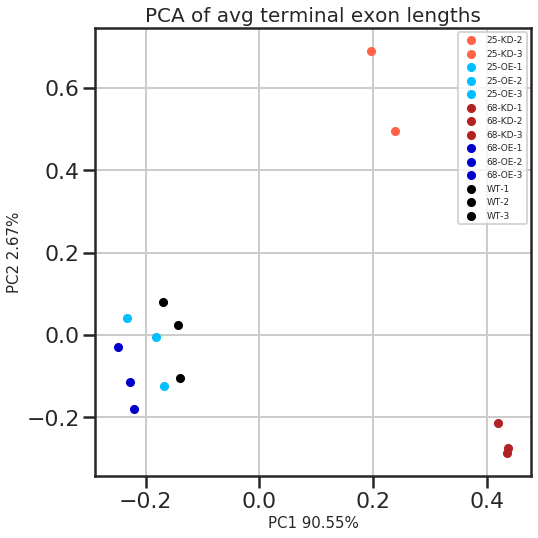

In [73]:
# plot the 2D projections on (PC1, PC2)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_title('PCA of avg terminal exon lengths', fontsize = 20)
ax.set_xlabel('PC1 '+str(pc1_var_utr[0])+'%', fontsize = 15)
ax.set_ylabel('PC2 '+str(pc2_var_utr[0])+'%', fontsize = 15)
colors = ["tomato","tomato","deepskyblue","deepskyblue","deepskyblue","firebrick","firebrick","firebrick","mediumblue","mediumblue","mediumblue","black","black","black"]

for i in range(len(samples_columns)):
    ax.scatter(plot_df.at[str(i+1),"PC1"], plot_df.at[str(i+1),"PC2"], c = colors[i], s = 50, label=samples_columns[i])

#make nice names for the legend
ax.legend(loc = 1, prop={'size': 9})
ax.grid()
plt.tight_layout()
plt.show()
fig.savefig(notebook_outdir + "/te_len_pca.pdf", format='pdf')
fig.savefig(notebook_outdir + "/te_len_pca.svg", format='svg')

In [74]:
pattern_pc1["abs[proj.z]"] = abs(pattern_pc1["proj.z"])
pattern_pc1["abs(cor)"] = abs(pattern_pc1["cor"])
pattern_pc1["gene_id"] = pattern_pc1.apply(lambda row: transcript_dict[row.name.split(":")[0]], axis=1)
pattern_pc1 = pattern_pc1.sort_values(by="abs[proj.z]", ascending=False)

full_corr_proj_df = pattern_pc1.copy()
full_corr_proj_df.index.name = "id"

Select CFI targets:

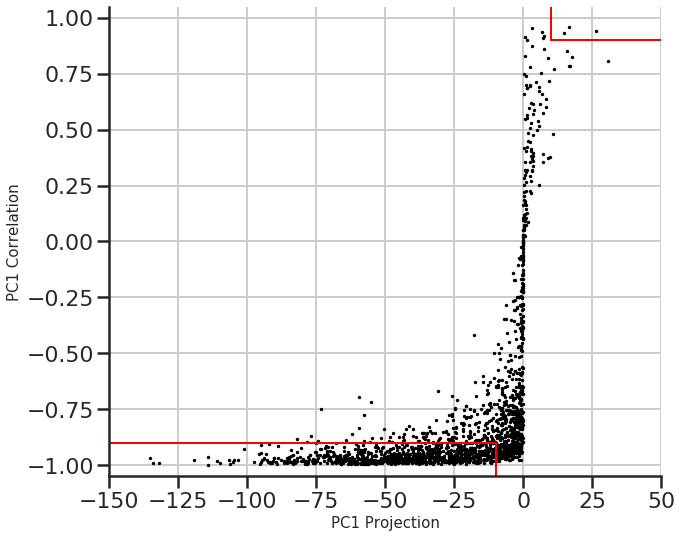

In [75]:
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(1,1,1) 
pattern_pc1.plot.scatter(x="proj", y="cor", ax=ax, s=2, c='black')
ax.plot([-200,-10], [-0.9,-0.9], color="red", linewidth=2)
ax.plot([-10,-10], [-0.9,-2], color="red", linewidth=2)
ax.plot([200,10], [0.9,0.9], color="red", linewidth=2)
ax.plot([10,10], [0.9,2], color="red", linewidth=2)
ax.set_xlabel('PC1 Projection', fontsize = 15)
ax.set_ylabel('PC1 Correlation', fontsize = 15)
plt.xlim([-150,50])
plt.ylim([-1.05,1.05])
plt.grid()
plt.tight_layout()
sns.despine()
plt.show()
fig.savefig(notebook_outdir + "/PC1_projections_vs_correlations.pdf", format='pdf')
fig.savefig(notebook_outdir + "/PC1_projections_vs_correlations.svg", format='svg')

In [76]:
# logs for the manuscript

pattern_pc1 = pattern_pc1[["proj", "proj.z", "abs[proj.z]", "cor", "abs(cor)", "gene_id"]].sort_values(by="proj")

print("full table:", len(pattern_pc1))
correlating = pattern_pc1[abs(pattern_pc1["cor"])>0.9].copy()
correlating_projecting = correlating[abs(correlating["proj"])>10.0].copy()
correlating_projecting = correlating_projecting.sort_values(by="proj")
print("|x| > 0.9 corr AND |x| > 10 proj:", len(correlating_projecting))
targets = correlating_projecting[(correlating_projecting["cor"]<-0.9) & (correlating_projecting["proj"]<-10)].sort_values(by="proj", ascending=True)
print("targets:", len(targets))

full table: 1750
|x| > 0.9 corr AND |x| > 10 proj: 858
targets: 855


In [77]:
pattern_pc1["CFI_target"] = pattern_pc1.apply(lambda row: row.name in targets.index.values, axis=1)
pattern_pc1.to_csv(notebook_outdir + "/full_pc1_proj_corr_scores.tsv", sep="\t")

---

Enrichment of _UGUA_ sequence motif in the proximity of the sites:

In [78]:
exon_targets = targets.index.values

targets_df_list = []
non_targets_df_list = []

for exon, df in usage_df_full.groupby(by="exon"):
    if len(df) == 2:
        if exon in exon_targets:
            targets_df_list.append(df)
        else:
            non_targets_df_list.append(df)

In [79]:
# As we will plot a region +/- 200nt of the sites we have to filter the terminal exons on that minimal distance.  

filtered_targets_df_list = []
difflist = []
for t in targets_df_list:
    templist = [int(i.split(':')[2]) for i in list(t["pas"])]
    diff = abs(templist[0] - templist[1])
    difflist.append(diff)
    if diff > 400:
        filtered_targets_df_list.append(t)
        
filtered_non_targets_df_list = []
difflist = []
for t in non_targets_df_list:
    templist = [int(i.split(':')[2]) for i in list(t["pas"])]
    diff = abs(templist[0] - templist[1])
    difflist.append(diff)
    if diff > 400:
        filtered_non_targets_df_list.append(t)

In [80]:
# divide pas for proximal and distal

targets_proximal = []
targets_distal = []

for df in filtered_targets_df_list:
    sites = list(df["pas"])
    strand = list(df["strand"])[0]
    if strand == "+":
        if int(sites[0].split(":")[2]) > int(sites[-1].split(":")[2]):
            targets_proximal.append(sites[-1])
            targets_distal.append(sites[0])
        else:
            targets_proximal.append(sites[0])
            targets_distal.append(sites[-1])
    elif strand == "-":
        if int(sites[0].split(":")[2]) > int(sites[-1].split(":")[2]):
            targets_proximal.append(sites[0])
            targets_distal.append(sites[-1])
        else:
            targets_proximal.append(sites[-1])
            targets_distal.append(sites[0])

# ---

nontargets_proximal = []
nontargets_distal = []

for df in filtered_non_targets_df_list:
    sites = list(df["pas"])
    strand = list(df["strand"])[0]
    if strand == "+":
        if int(sites[0].split(":")[2]) > int(sites[-1].split(":")[2]):
            nontargets_proximal.append(sites[-1])
            nontargets_distal.append(sites[0])
        else:
            nontargets_proximal.append(sites[0])
            nontargets_distal.append(sites[-1])
    elif strand == "-":
        if int(sites[0].split(":")[2]) > int(sites[-1].split(":")[2]):
            nontargets_proximal.append(sites[0])
            nontargets_distal.append(sites[-1])
        else:
            nontargets_proximal.append(sites[-1])
            nontargets_distal.append(sites[0])

In [81]:
# save +/- 200 regions around the pas into bed files

with open(notebook_outdir + "/tp.bed", "w") as f:
    for pas in targets_proximal:
        strand = pas.split(":")[-1]
        chrom = pas.split(":")[0]
        start = str(int(pas.split(":")[2]) - 200)
        end = str(int(pas.split(":")[2]) + 200)
        f.write("\t".join([chrom, start, end, pas, "0", strand])+"\n")

with open(notebook_outdir + "/td.bed", "w") as f:
    for pas in targets_distal:
        strand = pas.split(":")[-1]
        chrom = pas.split(":")[0]
        start = str(int(pas.split(":")[2]) - 200)
        end = str(int(pas.split(":")[2]) + 200)
        f.write("\t".join([chrom, start, end, pas, "0", strand])+"\n")

with open(notebook_outdir + "/np.bed", "w") as f:
    for pas in nontargets_proximal:
        strand = pas.split(":")[-1]
        chrom = pas.split(":")[0]
        start = str(int(pas.split(":")[2]) - 200)
        end = str(int(pas.split(":")[2]) + 200)
        f.write("\t".join([chrom, start, end, pas, "0", strand])+"\n")

with open(notebook_outdir + "/nd.bed", "w") as f:
    for pas in nontargets_distal:
        strand = pas.split(":")[-1]
        chrom = pas.split(":")[0]
        start = str(int(pas.split(":")[2]) - 200)
        end = str(int(pas.split(":")[2]) + 200)
        f.write("\t".join([chrom, start, end, pas, "0", strand])+"\n")

In [82]:
# importantly "s=True", i.e. Force strandedness. If the feature occupies the antisense, strand, the sequence will be reverse complemented.

BedTool = pybedtools.BedTool(notebook_outdir + "/tp.bed")
BedTool = BedTool.sequence(fi="./data/Homo_sapiens.GRCh38.dna_sm.primary_assembly.fa", s=True)
with open(notebook_outdir + "/tp.fasta", "w") as outfile:
    fasta_lines = open(BedTool.seqfn).read().splitlines()
    for i in range(0, len(targets_proximal)):
        outfile.write(fasta_lines[i*2] + "|" + targets_proximal[i] + os.linesep)
        outfile.write(fasta_lines[i*2 + 1].upper() + os.linesep)

BedTool = pybedtools.BedTool(notebook_outdir + "/td.bed")
BedTool = BedTool.sequence(fi="./data/Homo_sapiens.GRCh38.dna_sm.primary_assembly.fa", s=True)
with open(notebook_outdir + "/td.fasta", "w") as outfile:
    fasta_lines = open(BedTool.seqfn).read().splitlines()
    for i in range(0, len(targets_distal)):
        outfile.write(fasta_lines[i*2] + "|" + targets_distal[i] + os.linesep)
        outfile.write(fasta_lines[i*2 + 1].upper() + os.linesep)

BedTool = pybedtools.BedTool(notebook_outdir + "/np.bed")
BedTool = BedTool.sequence(fi="./data/Homo_sapiens.GRCh38.dna_sm.primary_assembly.fa", s=True)
with open(notebook_outdir + "/np.fasta", "w") as outfile:
    fasta_lines = open(BedTool.seqfn).read().splitlines()
    for i in range(0, len(nontargets_proximal)):
        outfile.write(fasta_lines[i*2] + "|" + nontargets_proximal[i] + os.linesep)
        outfile.write(fasta_lines[i*2 + 1].upper() + os.linesep)

BedTool = pybedtools.BedTool(notebook_outdir + "/nd.bed")
BedTool = BedTool.sequence(fi="./data/Homo_sapiens.GRCh38.dna_sm.primary_assembly.fa", s=True)
with open(notebook_outdir + "/nd.fasta", "w") as outfile:
    fasta_lines = open(BedTool.seqfn).read().splitlines()
    for i in range(0, len(nontargets_distal)):
        outfile.write(fasta_lines[i*2] + "|" + nontargets_distal[i] + os.linesep)
        outfile.write(fasta_lines[i*2 + 1].upper() + os.linesep)

In [83]:
# load sequences into dicts here and count UGUA(TGTA) occurances per position

with open(notebook_outdir + "/tp.fasta") as f:
    lines = f.read().splitlines()
    tp_seq = {lines[l].split("|")[-1]:lines[l+1] for l in range(0,len(lines),2)}
    assert len(tp_seq) == 771

with open(notebook_outdir + "/td.fasta") as f:
    lines = f.read().splitlines()
    td_seq = {lines[l].split("|")[-1]:lines[l+1] for l in range(0,len(lines),2)}
    assert len(td_seq) == 771

with open(notebook_outdir + "/np.fasta") as f:
    lines = f.read().splitlines()
    np_seq = {lines[l].split("|")[-1]:lines[l+1] for l in range(0,len(lines),2)}
    assert len(np_seq) == 740

with open(notebook_outdir + "/nd.fasta") as f:
    lines = f.read().splitlines()
    nd_seq = {lines[l].split("|")[-1]:lines[l+1] for l in range(0,len(lines),2)}
    assert len(nd_seq) == 740

def count_TGTA(L):
    result = [0] * len(L[0])
    for seq in L:
        countseq = [0] * len(L[0])
        TGTA_start_ind = [m.start() for m in re.finditer("TGTA", seq)]
        for _ in TGTA_start_ind: countseq[_] = 1.0
        result = [sum(_) for _ in zip(result, countseq)]
    return result

In [84]:
tp_counts = np.array(count_TGTA(list(tp_seq.values())))
td_counts = np.array(count_TGTA(list(td_seq.values())))
np_counts = np.array(count_TGTA(list(np_seq.values())))
nd_counts = np.array(count_TGTA(list(nd_seq.values())))

In [85]:
# normalize the data per n.o. sequences
tp_counts = tp_counts / 771
td_counts = td_counts / 771
np_counts = np_counts / 740
nd_counts = nd_counts / 740

In [86]:
# define a function to smoothen the curves

def avg_over_range(arr, rad=0):
    result = []
    for i in range(len(arr)):
        result.append(np.mean(arr[max(i-rad,0):min(i+1+rad,len(arr)+1)]))
    return result

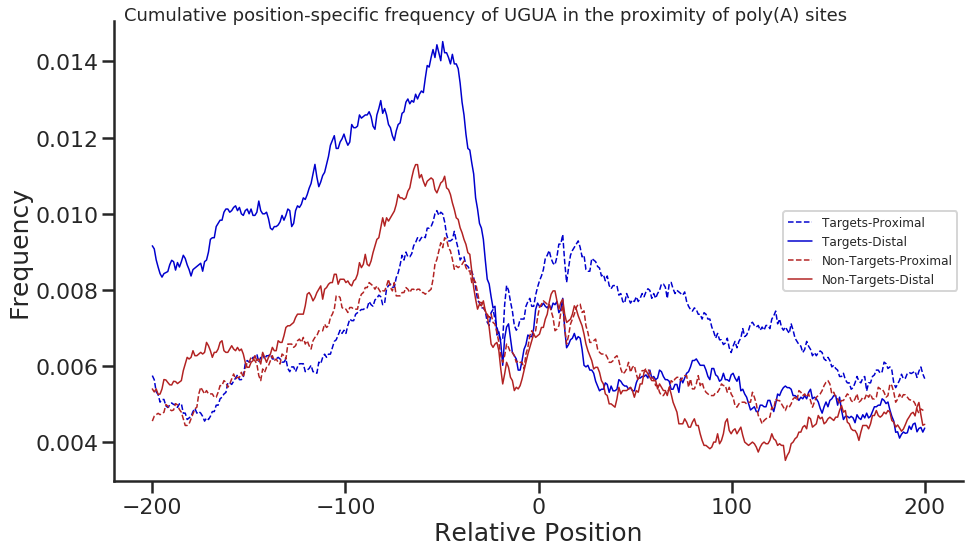

In [87]:
# plot the SMOOTHENED NORMALIZED cummulative position-specific frequency

x = np.linspace(-200,200,num=400)

fig, ax = plt.subplots(1, figsize=(14,8))
fig.suptitle("Cumulative position-specific frequency of UGUA in the proximity of poly(A) sites", size=18)

ax.plot(x, avg_over_range(tp_counts, 15), "--", label="Targets-Proximal", c="mediumblue", lw=1.5)
ax.plot(x, avg_over_range(td_counts, 15), "-", label="Targets-Distal", c="mediumblue", lw=1.5)

ax.plot(x, avg_over_range(np_counts, 15), "--", label="Non-Targets-Proximal", c="firebrick", lw=1.5)
ax.plot(x, avg_over_range(nd_counts, 15), "-", label="Non-Targets-Distal", c="firebrick", lw=1.5)

ax.set_xticks([-200,-100,0,100,200])

ax.set_xlabel('Relative Position', fontsize = 25)
ax.set_ylabel('Frequency', fontsize = 25)

ax.legend(prop={'size': 12}, loc=5)
sns.despine()
plt.tight_layout()
plt.show()
fig.savefig(notebook_outdir + "/UGUA_density.pdf", format='pdf')
fig.savefig(notebook_outdir + "/UGUA_density.svg", format='svg')

---